## DeepFace

Here we use models trained on the VGG-Face architecture for facial analysis (age, gender, race and emotion). The weights of the facial expression models are also downloaded.

In [14]:
from deepface import DeepFace
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

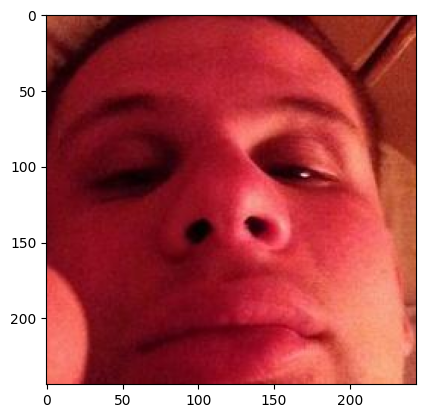

In [16]:
impath1 = r"C:\Users\terai\VSCode-projects\explainable-ai\affectnet\train_class\class001\image0000002.jpg"
impath2 = r"C:\Users\terai\VSCode-projects\explainable-ai\affectnet\train_class\class001\image0000221.jpg"

img = mpimg.imread(impath2)
imgplot = plt.imshow(img)
plt.show()

In [18]:
obj = DeepFace.analyze(img_path = impath1, actions = ['age', 'gender', 'race', 'emotion'])

Action: age:   0%|          | 0/4 [00:00<?, ?it/s]    

1/1 [==============================] - 0s 184ms/step


Action: gender:  25%|██▌       | 1/4 [00:01<00:04,  1.45s/it]

1/1 [==============================] - 0s 184ms/step


Action: race:  50%|█████     | 2/4 [00:01<00:01,  1.39it/s]  

1/1 [==============================] - 0s 184ms/step


Action: emotion:  75%|███████▌  | 3/4 [00:01<00:00,  2.06it/s]

1/1 [==============================] - 0s 24ms/step


Action: emotion: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]
